# Optimization projec: clustering

__Given that we don't have the proper datafiles to run the code, we will use synthetic ones to still do the work, and
as soon as we have the real files we will just substitute them.__

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
N = 200
#Simulate dataframe
X1 = np.random.uniform(low=0, high=25, size=N)
X2 = np.random.uniform(low=0, high=25, size=N)
df = pd.DataFrame({'X1': X1, 'X2': X2}, columns=['X1', 'X2'])

## Minimum Spanning Tree Clustering


## naive approach: compute all distances:

In [2]:
def MST_clustering(K, N, ordered_result):
    cluster_dict = {}
    k = 0
    vertex = []
    counter = 0
    i = 0
    final_number_clusters = N-K
    for ite in ordered_result:
        if counter == final_number_clusters:
            for ite in ordered_result[i:]:
                if ite[0] not in vertex:
                    k += 1
                    cluster_dict[k] = [ite[0]]
                    #df.Cluster.iloc[ite[0]] = k
                    vertex.append(ite[0])
                if ite[1] not in vertex:
                    k += 1
                    cluster_dict[k] = [ite[1]]  
                    #df.Cluster.iloc[ite[1]] = k
                    vertex.append(ite[1])
            return cluster_dict
        key_0 = -1
        key_1 = -1
        for cluster in cluster_dict:
            for el in cluster_dict[cluster]:
                if ite[0] == el:
                    key_0 = cluster
                    
        for cluster in cluster_dict:
            for el in cluster_dict[cluster]:
                if ite[1] == el: 
                    key_1 = cluster
        if (key_0 == -1) and (key_1 == -1):
            k += 1
            cluster_dict[k] = [ite[0]] 
            cluster_dict[k] += [ite[1]]
            counter +=1
            #df.Cluster.iloc[ite[0]] = k
            #df.Cluster.iloc[ite[1]] = k
            vertex.append(ite[0])
            vertex.append(ite[1])
        elif (key_0 == -1) and (key_1 != -1):
            cluster_dict[key_1] += [ite[0]]
            #df.Cluster.iloc[ite[0]] = key_1
            counter +=1
            vertex.append(ite[0])
        elif (key_0 != -1) and (key_1 == -1):
            cluster_dict[key_0] += [ite[1]]
            #df.Cluster.iloc[ite[1]] = key_0
            counter +=1
            vertex.append(ite[1])
        else:
            if key_0 == key_1:
                pass
            else:
                cluster_dict[key_0] += cluster_dict[key_1]
                #for el in cluster_dict[key_1]:
                    #df.Cluster.iloc[el] = key_0
                del cluster_dict[key_1]
                counter +=1
        i +=1
    return cluster_dict

# try to find out whether the range (2) thing actually works (last case)

In [455]:
%%time
cluster_dict = MST_clustering(199, 200, ordered_result)

CPU times: user 139 ms, sys: 4.69 ms, total: 143 ms
Wall time: 154 ms


In [456]:
len(cluster_dict)

199

In [457]:
import matplotlib.pyplot as plt
import seaborn as sns

In [458]:
ind_list = []
clust_list = []
for k, v in cluster_dict.items():
    [clust_list.append(k) for i in v]
    [ind_list.append(val) for val in v]
df_s = pd.DataFrame()
df_s['indices'] = ind_list
df_s['cluster'] = clust_list
cluster = df_s.sort_values('indices').cluster
cluster = cluster.reset_index(drop=True)

In [459]:
df['Cluster'] = cluster

In [460]:
df

X1         X2
0    20.060878  21.965207
1     8.259858  17.998107
2     7.462406  19.675533
3    22.074943  19.540668
4     8.975622   9.842485
..         ...        ...
195   1.659980   7.337579
196   3.127837  10.529380
197  10.272187  13.480077
198   6.999000  18.326592
199  11.132592  18.056344

[200 rows x 3 columns]

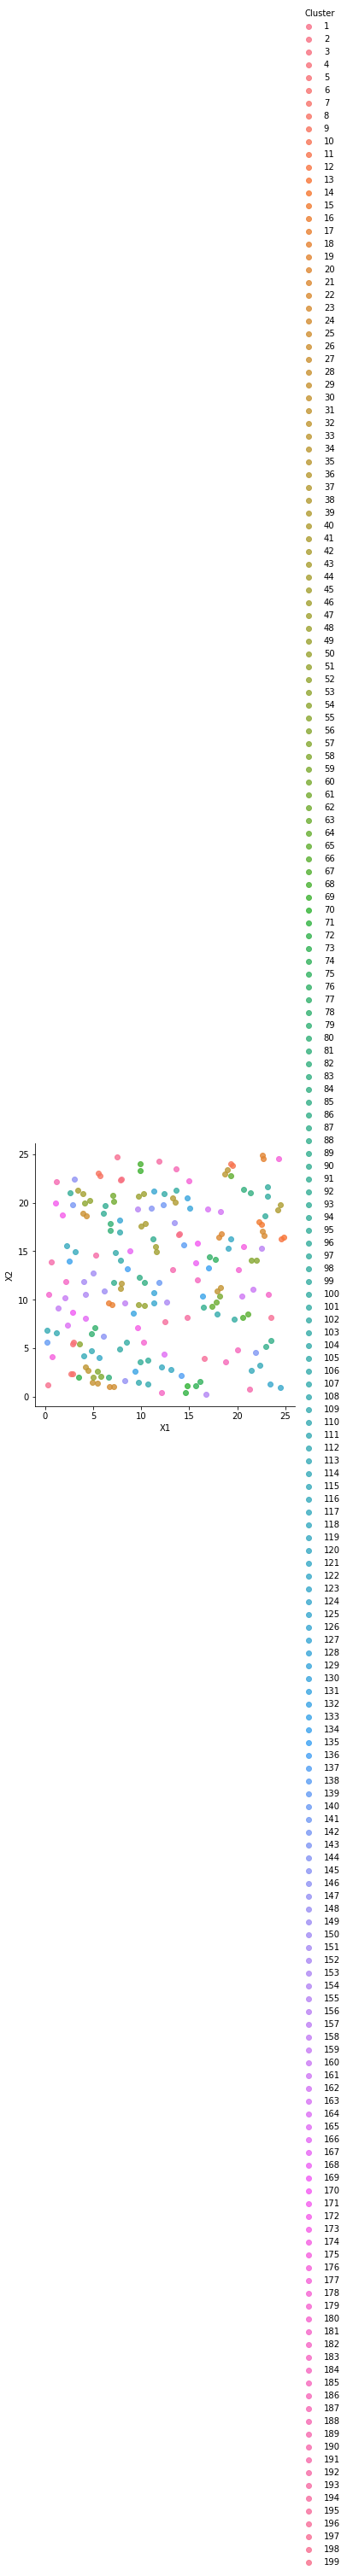

In [461]:
import seaborn as sns
sns.lmplot(x='X1', y='X2', hue='Cluster', data=df, fit_reg = False)

## The Davies-Bouldin index

 - First of all let's compute the centroid of each cluster

In [462]:
def Davies_Bouldin(cluster_dict,df):
    clusters = []
    for n in cluster_dict:
        clusters.append(n)
    centroid_dict = {}
    for n in clusters:
        mask = (df.Cluster == n)
        nice = df[mask]
        centroid = nice.mean()
        centroid = centroid.to_list()
        centroid_dict[n] = [centroid[0],centroid[1]]
    S_i = {}
    for n in cluster_dict:
        sum_ = 0
        for el in cluster_dict[n]:
            sum_ += np.linalg.norm(np.array([df.iloc[el][0], df.iloc[el][1]]) - 
                               np.array([centroid_dict[n][0], centroid_dict[n][1]]))
            average = sum_/len(cluster_dict[n])
            S_i[n] = average
    M_ij = {}
    centroids = list(centroid_dict.keys())
    for i in range(0,len(centroids)):
        for j in range(i+1,len(centroids)):
            distance = np.linalg.norm(np.array([centroid_dict[centroids[i]][0], centroid_dict[centroids[i]][1]]) 
                                  - np.array([centroid_dict[centroids[j]][0], centroid_dict[centroids[j]][1]]))
            M_ij[(centroids[i],centroids[j])] = distance 
    dispersion = list(S_i.keys())
    D_i = {}
    for i in range(0, len(dispersion)):
        D_i[dispersion[i]] = 0
        for j in range(0,len(dispersion)):
            if i!=j:
                try:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[i],dispersion[j])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                except:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[j],dispersion[i])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
    count = 0
    for n in D_i:
        count += D_i[n]
    DB = count/len(D_i)
    return DB

In [463]:
DB = Davies_Bouldin(cluster_dict,df)

In [464]:
DB

0.007963598081933025

In [465]:
from sklearn.metrics import davies_bouldin_score

In [314]:
foodict

{27: [[169, 185],
  [38, 185],
  [74, 101],
  [3, 74],
  [120, 122],
  [80, 184],
  [68, 184],
  [147, 188],
  [46, 131],
  [94, 173],
  [87, 173],
  [94, 128],
  [149, 179],
  [10, 149],
  [17, 119],
  [61, 119],
  [61, 90],
  [10, 75],
  [90, 96],
  [104, 114],
  [104, 153],
  [76, 153],
  [108, 168],
  [108, 123],
  [36, 91],
  [45, 91],
  [45, 62],
  [5, 129],
  [39, 56],
  [0, 146],
  [0, 93],
  [20, 146],
  [20, 152],
  [93, 103],
  [113, 152],
  [59, 163],
  [163, 176],
  [8, 176],
  [59, 116],
  [27, 98],
  [7, 29],
  [73, 118],
  [145, 181],
  [6, 159],
  [70, 107],
  [145, 165],
  [48, 69],
  [69, 172],
  [150, 189],
  [28, 141],
  [141, 154],
  [33, 37],
  [15, 33],
  [83, 115],
  [77, 83],
  [115, 183],
  [102, 170],
  [85, 170],
  [132, 167],
  [97, 167],
  [63, 65],
  [63, 86],
  [16, 85],
  [100, 148],
  [157, 190],
  [106, 140],
  [105, 140],
  [44, 126],
  [35, 134],
  [35, 111],
  [25, 134],
  [40, 195],
  [31, 160],
  [31, 50],
  [26, 58],
  [26, 109],
  [9, 162],
  

In [ ]:
label = df.Cluster.to_list()

In [467]:
db = davies_bouldin_score(df.drop('Cluster',axis=1), labels = label)

In [468]:
db

0.007963598081893007